# K-means Clustering

我们将先用图像展示K-means算法，再将聚类算法用于图像压缩--减少图像中出现的颜色数量，只保留那些在图像中最常见的颜色

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

In [2]:
from jupyterthemes import jtplot
jtplot.style()

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

## 1. Implementing K-means

### 变量初始化

In [4]:
data1 = loadmat("data1.mat")
data1.keys()
X = data1["X"]
type(X),X.shape

dict_keys(['__header__', '__version__', '__globals__', 'X'])

(numpy.ndarray, (300, 2))

<Figure size 576x360 with 0 Axes>

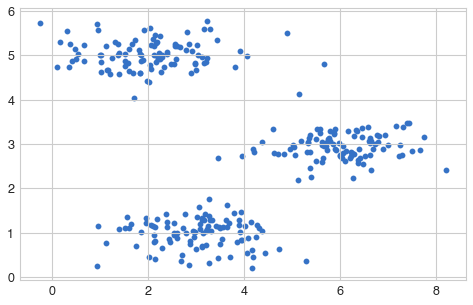

In [5]:
plt.figure(figsize=(8,5))
plt.scatter(X[:,0],X[:,1])
plt.grid(True)

从图中可以看出，应该分成3类，同时数据的量纲相同，不需要做feature scaling

### Random Initialization

In [6]:
def RandomInitalCentroids(X,K):
    m,n = X.shape
    idex = np.random.choice(m,K)
    centroids = X[idex,:]
    return centroids

### Find closest centroids

In [7]:
def findClosestCentroids(X, centroids):
    K = centroids.shape[0]
    idx = np.zeros(X.shape[0])
    for i in range(len(X)):
        adj=(X[i,:]-centroids[0,:])@(X[i,:]-centroids[0,:]).T
        idx[i]=0
        for j in range(1,K):
            temp=(X[i,:]-centroids[j,:])@(X[i,:]-centroids[j,:]).T
            if temp < adj:
                idx[i]=j #python下标从0开始，所以我们将聚类第一类用0指代
                adj=temp
    return idx.astype(int)#将index转化为整型

### Computing centroid means

In [8]:
def computeCentroids(X,idx):
    m,n = X.shape
    K = len(np.unique(idx))
    centroids = np.zeros((K,n))
    for i in range(K):
        if sum(idx == i) == 0:
            centroids[i,:]=np.zeros((1,n))
        else:
            centroids[i,:]=X[idx==i,:].mean(axis=0)#求每一列的平均值
    return centroids

### Run K-means

In [9]:
def runKmeans(X, centroids, max_iters):
    K = centroids.shape[0]
    centroids_all = []#这里我们是为了画图，将保留每一次迭代的值
    centroids_all.append(centroids)
    centroid_i = centroids
    for i in range(max_iters):
        idx = findClosestCentroids(X,centroid_i)
        centroid_i = computeCentroids(X,idx)
        centroids_all.append(centroid_i)
    return idx, centroids_all

### Plot the procedure of algorithm

In [10]:
def plotProcedure(X,centroids_all,idx):
    colors = ['b','g','gold','darkorange','salmon','olivedrab', 
              'maroon', 'navy', 'sienna', 'tomato', 'lightgray', 'gainsboro'
              'coral', 'aliceblue', 'dimgray', 'mintcream', 'mintcream']
    K = centroids_all[0].shape[0]
    assert K <= len(colors), 'colors not enough ' #断言语句，如果条件语句为假，则返回后面字符串
    Clustered_X = []
    for i in range(K):
        X_cluster_i = X[idx==i,:]
        Clustered_X.append(X_cluster_i)
        
    #用不同的颜色，画不同的cluster
    plt.figure(figsize=(8,5))
    for i in range(len(Clustered_X)):
        xx = Clustered_X[i]
        plt.scatter(xx[:,0],xx[:,1],c=colors[i],label="Cluster {}".format(i))
    plt.legend()
    plt.grid(True)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title("The plot for procedure of algorithm")
    
    #画centroids的移动轨迹
    xx,yy =[],[]
    for centroid in centroids_all:
        xx.append(centroid[:,0])
        yy.append(centroid[:,1])
    plt.plot(xx,yy,"--",c="red",marker="o",markersize=6)

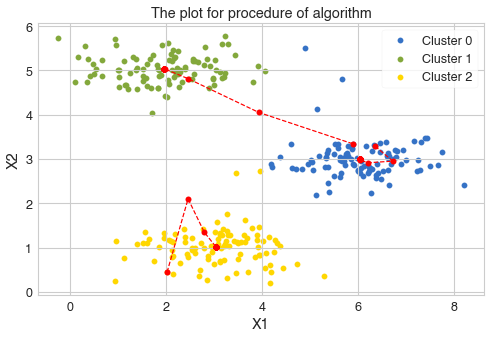

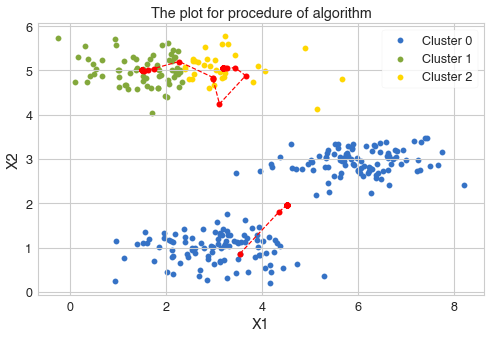

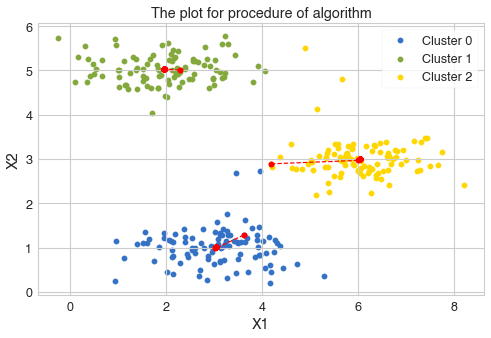

In [11]:
for i in range(3):
    centroids = RandomInitalCentroids(X, 3)
    idx, centroids_all = runKmeans(X, centroids, 20)
    plotProcedure(X, centroids_all, idx)

不同的随机初始化，效果不同，落入的局部最优解也不同，所以需要多次随机初始化，并选取cost最小的那组解

### Cost function

In [12]:
def CostFunction(X,centroid,idx):
    K = centroid.shape[0]
    cost_cluster = []
    for i in range(K):
        vector = np.power((X[idx==i,:]-centroid[i,:]),2)#广播
        cost_i = np.sum(vector)
        cost_cluster.append(cost_i)
    return sum(cost_cluster)

### Random Initialize 100 times to select the "best" result

In [13]:
def bestClustering(X,K,times,max_iters):
    Cost = None
    final_idx = None
    final_centroids_all = None
    for i in range(times):
        centroids = RandomInitalCentroids(X,K)
        idx, centroids_all = runKmeans(X, centroids, max_iters)
        centroid = centroids_all[-1]
        temp = CostFunction(X,centroid,idx)
        if Cost is None:
            Cost = temp
            final_idx = idx
            final_centroids_all = centroids_all
        elif temp < Cost:
            Cost = temp
            final_idx = idx
            final_centroids_all = centroids_all
    return final_idx, final_centroids_all

In [14]:
final_idx,final_centroids_all = bestClustering(X,3,100,20)

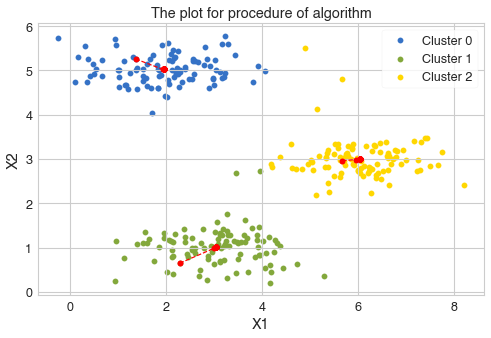

In [15]:
plotProcedure(X, final_centroids_all, final_idx)

## 2. Image compression with K-means

这部分你将用Kmeans来进行图片压缩。在一个简单的24位颜色表示图像。每个像素被表示为三个8位无符号整数(从0到255)，指定了红、绿和蓝色的强度值。这种编码通常被称为RGB编码。我们的图像包含数千种颜色，在这一部分的练习中，你将把颜色的数量减少到16种颜色<br/>

这可以有效地压缩照片。具体地说，您只需要存储16个选中颜色的RGB值，而对于图中的每个像素，现在只需要将该颜色的索引存储在该位置(只需要4 bits就能表示16种可能性)<br/>

接下来我们要用K-means算法选16种颜色，用于图片压缩。你将把原始图片的每个像素看作一个数据样本，然后利用K-means算法去找分组最好的16种颜色

In [6]:
from skimage import io #package for image

In [7]:
image = io.imread("bird_small.png")
image.shape

(128, 128, 3)

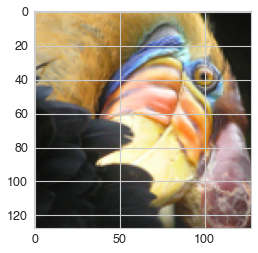

In [8]:
plt.imshow(image)

In [9]:
image = image/255. #二值化 浮点型

In [10]:
#  Reshape the image into an (N,3) matrix where N = number of pixels.
#  Each row will contain the Red, Green and Blue pixel values
#  This gives us our dataset matrix X that we will use K-Means on.
X = image.reshape(-1,3)
X.shape

(16384, 3)

我们选择用16中颜色大类来聚类所有颜色

In [11]:
K=16
final_idx,final_centroids_all = bestClustering(X,K,1,20)

NameError: name 'bestClustering' is not defined

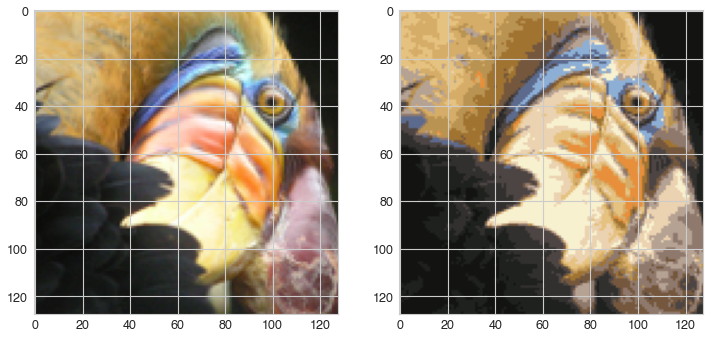

In [22]:
new_image = np.zeros(X.shape)
centroid = final_centroids_all[-1]
#用聚类出来的每一类的centroid来替代属于这一类的所有颜色的值
for i in range(K):
    new_image[final_idx == i,:] = centroid[i,:]
    
new_image = new_image.reshape((128,128,3))

fig,axes = plt.subplots(1,2,figsize=(12,6))
axes[0].imshow(image)
axes[1].imshow(new_image)